In [2]:
# from map_evaluation import P_wrapper, Evaluator, NNinv_keras, NNinv_torch, MapBuilder
import sys
import os
sys.path.append('../sdbm/code/')
sys.path.append('../DeepView/deepview/')
sys.path.append('../dbm_evaluation/')
from map_evaluation import MapBuilder #P_wrapper, Evaluator, NNinv_keras, NNinv_torch, 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE, MDS
# import make blobs
from sklearn.datasets import make_blobs, load_iris
from lamp import Pinv_ilamp
from NNinv import NNinv_torch
from rbf_inv import RBFinv
from multilateration import MDSinv
# date
from datetime import datetime

from umap import UMAP

from tqdm import tqdm

from ssnp import SSNP



/home/peyote/.conda/envs/tf3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-21 17:52:20.769557: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-21 17:52:20.801679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 17:52:20.801704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 17:52:20

(100, 3)


/tmp/ipykernel_41964/488546496.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pinot_clor_map = cm.get_cmap(CMAP)


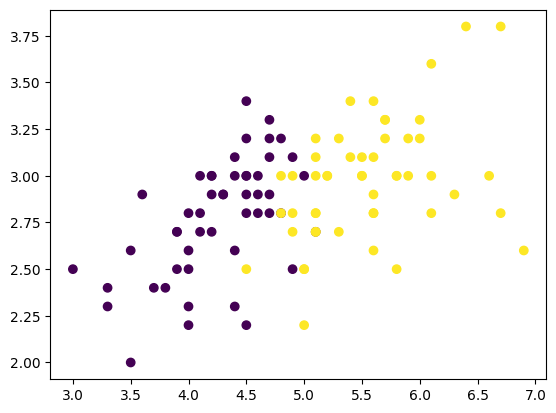

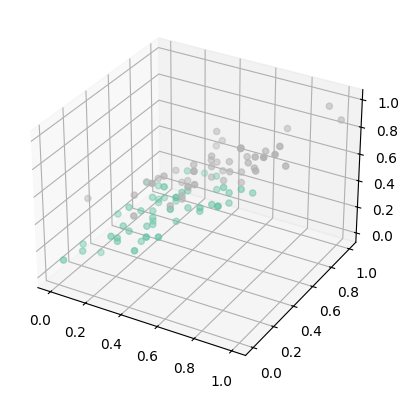

In [4]:
# # %matplotlib widget
# blob0 = make_blobs(n_samples=300, n_features=3, centers=3, cluster_std=1.0, random_state=666)
# # blob0 = make_blobs(n_samples=150, n_features=3, centers=5, cluster_std=1.2, random_state=6666)
# y = blob0[1]

####################################3
## Load iris data

iris = load_iris()
# ind = y != 0
ind = np.where(iris.target != 0)[0]

X = iris.data[ind, :3]
y = iris.target[ind]
y = y - 1
blob0 = [X, y]
# visualize
plt.scatter(X[:,2], X[:,1], c=y, cmap='viridis')

print(X.shape)
#############################
# plot the blobs in 3D"
fig_3d = plt.figure()
ax_3d = fig_3d.add_subplot(111, projection='3d')
# ax.vieinit() what is the default view? type help(ax.vieinit)
# help(ax.vieinit)
CMAP = 'Set2'
pinot_clor_map = cm.get_cmap(CMAP)
ponit_clor = pinot_clor_map(y/y.max())

#####
lazy_scaler = MinMaxScaler()
blob0 = list(blob0)
blob0[0] = lazy_scaler.fit_transform(blob0[0])
#####

ax_3d.scatter(blob0[0][:,0], blob0[0][:,1], blob0[0][:,2], c=ponit_clor, )#cmap='tab10', )

In [5]:
class Simple_P_wrapper:
    def __init__(self, P, Pinv):
        self.P = P
        self.Pinv = Pinv
    def __call__(self, x):
        return self.P(x)
    def transform(self, x):
        return self.P.transform(x)
    def inverse_transform(self, x):
        return self.Pinv.transform(x)

    def fit(self, x, y=None, clf=None):
        X2d = self.P.fit_transform(x)
        self.X2d = X2d
        self.Pinv.fit(X2d, x )
        return self

# p = UMAP(n_components=2, random_state=0, n_neighbors=30, min_dist=0.9)
P = TSNE(n_components=2, random_state=0)
P = MDS(n_components=2, random_state=0)
# Pinv = NNinv_torch(dims=[2048]*4)
Pinv = Pinv_ilamp()
ilamp = Simple_P_wrapper(P, Pinv)
nninv = Simple_P_wrapper(P, NNinv_torch())
ssnp = SSNP(bottleneck_activation='linear', )
mdsinv_rand = Simple_P_wrapper(P, MDSinv())
mdsinv_near = Simple_P_wrapper(P, MDSinv(point_selection='nearest'))
rbf_inv = Simple_P_wrapper(P, RBFinv())

device:  cuda:0


In [6]:
scaler = MinMaxScaler()
X = scaler.fit_transform(blob0[0])
# X = blob0[0]
y = blob0[1]

# NNinv_keras = 0
# NNinv_torch = 1
# deepview = 0
# ssnp = 0

# name_list = ['NNinv_keras', 'NNinv_torch', 'deepview', 'ssnp']
#get the none zero name
# name_plot = [name_list[i] for i in [NNinv_keras, NNinv_torch, deepview, ssnp] if i != 0][0]

# ssnp = SSNP(patience=5, opt='adam', bottleneck_activation='linear', verbose=0)
# proj = P_wrapper(NNinv_Keras=NNinv_keras, NNinv_Torch=NNinv_torch, deepview=deepview, ssnp=ssnp)

# # clf = SVC(probability=True)
# # clf = RandomForestClassifier()
# dbm = P_wrapper(NNinv_Torch=1, deepview=0, ssnp=0, NNinv_Keras=0)
# ssnp = P_wrapper(NNinv_Keras=0, NNinv_Torch=0, deepview=0, ssnp=1)
# DV = P_wrapper(NNinv_Keras=0, NNinv_Torch=0, deepview=1, ssnp=0)

clf = linear_model.LogisticRegression()
clf.fit(X, y)
ilamp.fit(X, y, clf)
nninv.fit(X, y, clf)
ssnp.fit(X, y)
mdsinv_rand.fit(X, y, clf)
rbf_inv.fit(X, y, clf)
# DV.fit(X, y, clf, lam=0.65)
# dbm.fit(X, y, clf)
# ssnp.fit(X, y, clf)


/home/peyote/.conda/envs/tf3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/peyote/.conda/envs/tf3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Early stopping at epoch 43
Epoch 1/100


2024-03-21 17:52:43.742596: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 17:52:43.743410: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 17:52:43.743501: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

3/3 [==============================] - 2s 96ms/step - loss: 3.2015 - main_output_loss: 0.6922 - decoder_output_loss: 0.6930 - main_output_accuracy: 0.6105 - decoder_output_accuracy: 0.3158 - val_loss: 3.1620 - val_main_output_loss: 0.6803 - val_decoder_output_loss: 0.6927 - val_main_output_accuracy: 1.0000 - val_decoder_output_accuracy: 0.4000
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 3.1525 - main_output_loss: 0.6844 - decoder_output_loss: 0.6923 - main_output_accuracy: 0.6000 - decoder_output_accuracy: 0.3789 - val_loss: 3.1151 - val_main_output_loss: 0.6738 - val_decoder_output_loss: 0.6924 - val_main_output_accuracy: 1.0000 - val_decoder_output_accuracy: 0.4000
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 3.0961 - main_output_loss: 0.6690 - decoder_output_loss: 0.6914 - main_output_accuracy: 0.8421 - decoder_output_accuracy: 0.3684 - val_loss: 3.0257 - val_main_output_loss: 0.6248 - val_decoder_output_loss: 0.6915 - val_main_

/home/peyote/.conda/envs/tf3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/peyote/.conda/envs/tf3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [7]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
# map_builder = MapBuilder(clf, ssnp, X, y, grid=100)
# ax_grad = map_builder.plot_gradient_map(ax=ax1)
# dv_map = map_builder.plot_prob_map(ax=ax2)
# plt.show()

4/4 [==============================] - 0s 981us/step


[]

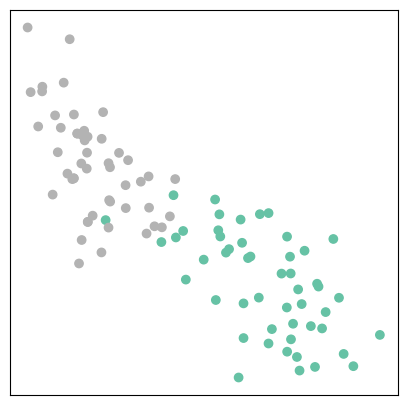

In [8]:
X_2d = ssnp.transform(blob0[0])
# scale the data to be between 0 and 1
# scaler2d = MinMaxScaler()
# X_2d = scaler2d.fit_transform(X_2d)


fig, ax = plt.subplots(figsize=(5,5) )
ax.scatter(X_2d[:,0], X_2d[:,1], c=ponit_clor)
# no ticks
ax.set_xticks([])
ax.set_yticks([])
# suqare aspect ratio`
# ax.set_aspect('equal')
# make directory if it doesn't exist
# if not os.path.exists('./figures/inlustrate_dbm'):
#     os.makedirs('./figures/inlustrate_dbm')
# fig.savefig('./figures/inlustrate_dbm/2d_1')

In [13]:
# %matplotlib widget
GRID = 100
CMAP = 'cividis'


313/313 [==============================] - 0s 545us/step
(10000, 3)
(100, 100, 4)
(100, 100)


/tmp/ipykernel_41964/1018270782.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10 = cm.get_cmap(CMAP)
100%|██████████| 9997/9997 [00:00<00:00, 299546.06it/s]
/tmp/ipykernel_41964/1018270782.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10 = cm.get_cmap(CMAP)


(10000, 3)
(100, 100, 4)
(100, 100)
(10000, 3)
(100, 100, 4)
(100, 100)


/tmp/ipykernel_41964/1018270782.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10 = cm.get_cmap(CMAP)


(10000, 3)
(100, 100, 4)
(100, 100)


/tmp/ipykernel_41964/1018270782.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10 = cm.get_cmap(CMAP)


Phi_new:  (10000, 100)
(10000, 3)
(100, 100, 4)
(100, 100)


/tmp/ipykernel_41964/1018270782.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10 = cm.get_cmap(CMAP)


Text(0.5, 0.92, 'RBF')

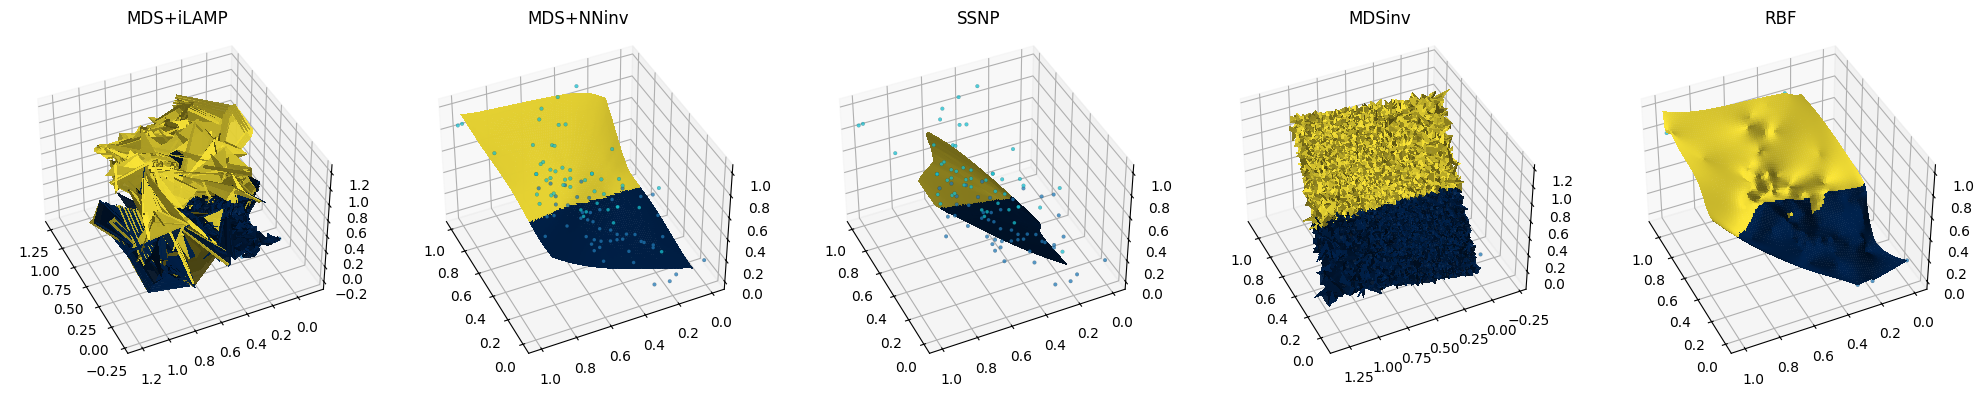

In [14]:
def plot_inverse_map(P_inv, GRID=GRID, clf=clf, ax=None, CMAP=CMAP):
    try:
        X_2d = P_inv.X2d
    except AttributeError:
        X_2d = P_inv.transform(blob0[0])
    xx, yy = np.meshgrid(np.linspace(X_2d[:,0].min(), X_2d[:,0].max(), GRID), np.linspace(X_2d[:,1].min(), X_2d[:,1].max(), GRID))
    XY = np.c_[xx.ravel(), yy.ravel()]
    XY_3d = P_inv.inverse_transform(XY)
    print(XY_3d.shape)
    XY_3d = scaler.inverse_transform(XY_3d)
    labels = clf.predict(XY_3d)
    ## grids with labels
    tab10 = cm.get_cmap(CMAP)
    labels_color = tab10(labels/labels.max())
    labels_color_2d = tab10(labels.reshape(GRID,GRID)/labels.max())
    # set alpha to 0.5
    labels_color_2d[:, : ,3] = 0.95
    print(labels_color_2d.shape)
    print(XY_3d[:,0].reshape(GRID,GRID).shape)
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    # ax_grid_dbm.scatter(XY_3d[:,0], XY_3d[:,1], XY_3d[:,2], c=labels_color[:], alpha=0.9, marker='+', cmap = 'tab10', s=100)
    ax.scatter(blob0[0][:,0], blob0[0][:,1], blob0[0][:,2], c=blob0[1], cmap='tab10', ec='k', s=7, linewidth=0.1, alpha=0.75)

    # ax_grid_dbm.plot_wireframe(XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), colors=labels_color, alpha=0.5,)
    ax.plot_surface(
        XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), facecolors=labels_color_2d, #shade=False, #alpha=0.5, 
          linewidth=0.0, antialiased=False, rstride=1, cstride=1, )
    
    ratio = 0.1
    # ax.set_xlim(blob0[0][:,0].min()+ratio, blob0[0][:,0].max()*.9)
    # ax.set_ylim(blob0[0][:,1].min()+ratio, blob0[0][:,1].max()*.9)
    # ax.set_zlim(blob0[0][:,2].min()+ratio, blob0[0][:,2].max()*.9)
    # # # Make panes transparent
    # ax.xaxis.pane.fill = False # Left pane
    # ax.yaxis.pane.fill = False # Right pane
    # ax.zaxis.pane.fill = False # Right pane

    # # Remove grid lines
    # ax.grid(False)

    # # Remove tick labels
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    # ax.set_zticklabels([])

    # # Transparent spines
    # ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    # ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    # ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    # # Transparent panes
    # ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # # No ticks
    # ax.set_xticks([]) 
    # ax.set_yticks([]) 
    # ax.set_zticks([])

    # backgroud color
    ax.set_facecolor((0.95, 0.95, 0.95, 0.0))
    ax.view_init(40, 155)

# plot_inverse_map(dbm)
# plt.show()
fig_3d = plt.figure(figsize=(25,5))
ax_ilmap = fig_3d.add_subplot(151, projection='3d')
ax_nninv = fig_3d.add_subplot(152, projection='3d')
ax_ssnp = fig_3d.add_subplot(153, projection='3d')
ax_mdsinv = fig_3d.add_subplot(154, projection='3d')
ax_mdsinv_near = fig_3d.add_subplot(155, projection='3d')
plot_inverse_map(ssnp, ax=ax_ssnp)
plot_inverse_map(ilamp, ax=ax_ilmap)
plot_inverse_map(nninv, ax=ax_nninv)
plot_inverse_map(mdsinv_rand, ax=ax_mdsinv)
plot_inverse_map(rbf_inv, ax=ax_mdsinv_near)

# set title
ax_ilmap.set_title('MDS+iLAMP')
ax_nninv.set_title('MDS+NNinv')
ax_ssnp.set_title('SSNP')
ax_mdsinv.set_title('MDSinv')
ax_mdsinv_near.set_title('RBF')



In [11]:
mdsinv_near.inverse_transform(np.array([[0.5, 0.5]]))

AttributeError: 'MDSinv' object has no attribute 'X'

calculating probability map
calculating probability map


100%|██████████| 22495/22495 [00:00<00:00, 268357.10it/s]


calculating probability map


Text(0.5, 1.0, 'MDS + iLAMP')

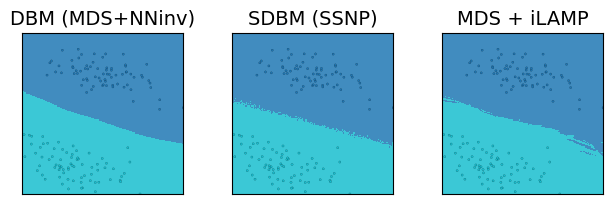

In [14]:
# build a fig with 3 3d-axes
fig = plt.figure(figsize=(7.5,3.5))
ax1 = fig.add_subplot(131,  )
ax2 = fig.add_subplot(132, )
ax3 = fig.add_subplot(133, )
# white space between subplots
fig.subplots_adjust(wspace=0.3, hspace=0.0)

dbm_builder = MapBuilder(clf, nninv, X, y, grid=150)
dbm_builder.plot_prob_map(ax=ax1,  proba=False)
# ssnp_builder = MapBuilder(clf, ssnp, X, y, grid=150)
# ssnp_builder.plot_prob_map(ax=ax2, proba=False)
DV_builder = MapBuilder(clf, ilamp, X, y, grid=150)
DV_builder.plot_prob_map(ax=ax3,  proba=False)
mds_builder = MapBuilder(clf, mdsinv_rand, X, y, grid=150)
mds_builder.plot_prob_map(ax=ax2,  proba=False)

aspect_ratio = 1.0
ax1.set_aspect(aspect_ratio)
ax2.set_aspect(aspect_ratio)
ax3.set_aspect(aspect_ratio)

# plot training data
dbm_builder.plot_training_data(ax=ax1, ec='k', linewidth=0.1)
# ssnp_builder.plot_training_data(ax=ax2, ec='k', linewidth=0.1 )
mds_builder.plot_training_data(ax=ax2, ec='k', linewidth=0.1 )
DV_builder.plot_training_data(ax=ax3, ec='k', linewidth=0.1 )

# not legend
ax1.legend().remove()
ax2.legend().remove()
ax3.legend().remove()

ax1.set_title('DBM (MDS+NNinv)', fontsize=14)
ax2.set_title('SDBM (SSNP)', fontsize=14)
ax3.set_title('MDS + iLAMP', fontsize=14)

# fig.savefig(r'..\papers\Intrinsic_Dim_paper\figures\2d_all.pdf', dpi=300, bbox_inches='tight')
# fig.savefig(r'..\papers\Intrinsic_Dim_paper\figures\2d_all.png', dpi=300, bbox_inches='tight')

In [11]:
# %matplotlib qt

In [12]:
# # use vispy to create a 3d mesh with color for X_3d and labels

# import vispy
# from vispy import app, scene
# from vispy.scene import visuals
# from vispy.visuals.transforms import STTransform

# # Create canvas
# canvas = scene.SceneCanvas(keys='interactive', show=True)
# # canvas.size = 800, 600
# canvas.show()

# # Create a ViewBox to display the cube with interactive arcball
# view = canvas.central_widget.add_view()
# view.camera = 'turntable'  # or try 'arcball'
# # white background
# view.bgcolor = [.8, .8, .8, 1]


# # Add a colored 3D axis for orientation
# # axis = scene.visuals.XYZAxis(parent=view.scene)

# ## plot blob as small spheres
# print(type(blob0[0]))
# vis = scene.visuals.Markers(
#     pos=blob0[0],
#     size=10,
#     antialias=0,
#     face_color=ponit_clor,
#     edge_color='white',
#     edge_width=0,
#     # scaling=True,
#     # spherical=True,
# )
# vis.parent = view.scene

# ## plot vertices as small spheres
# print(type(XY_3d))
# gridnd = scene.visuals.Markers(
#     pos=XY_3d,
#     size=10,
#     antialias=0,
#     face_color='black',
#     edge_color='white',
#     edge_width=0,
#     scaling=False,
    
#     # spherical=True,  
# )

# gridnd.parent = view.scene

# gridnd_labeled = scene.visuals.Markers(
#     pos=XY_3d,
#     size=10,
#     antialias=0,
#     face_color=labels_color,
#     edge_color='white',
#     edge_width=0,
#     scaling=False,
    
#     # spherical=True,  
# )
# gridnd_labeled.parent = None


# # turn the 3d points into a faces
# faces = []
# for i in range(0, GRID-1, 2):
#     for j in range(0, GRID-1, 2):
#         faces.append([i, i+1, j, j+1])
   
# # create the mesh
# # mesh = vispy.visuals.surface_plot.SurfacePlotVisual(XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID))
# mesh = visuals.SurfacePlot(XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), parent=view.scene) #, shading='flat'
# # add the mesh to the view
# # view.add(mesh)
# # (vertices=XY_3d.reshape(GRID, GRID, 3), parent=view.scene,)

# mesh2 = visuals.SurfacePlot(XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), parent=view.scene) #, shading='flat'
# mesh3 = visuals.SurfacePlot(XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), parent=view.scene) #, shading='flat'

# ## surface
# # mesh = scene.visuals.Mesh(XY_3d.reshape(GRID,GRID,3),  parent=view.scene)
# # set color vertices color to labels and set face color to None
# color_to_plot = [id_color,  labels_color, grads_color]
# for i in range(3):
#     # color_to_plot[i] = color_to_plot[i].reshape(GRID,GRID,4)
#     color_to_plot[i][:,3] = 0.9

# # set ahpha to 0.5
# # color_to_plot[:,3] = 0.7

# cur_ind = 0
# mesh.mesh_data.set_vertex_colors(color_to_plot[0])
# mesh2.mesh_data.set_vertex_colors(color_to_plot[1])
# mesh3.mesh_data.set_vertex_colors(color_to_plot[2])



# #draw the mesh by draw lines
# lines = []
# for h_line in XY_3d.reshape(GRID,GRID,3):
#     hline = scene.visuals.Line(pos=h_line, color='k', parent=view.scene, width=3)
#     lines.append(hline)
# for v_line in XY_3d.reshape(GRID,GRID,3).transpose(1,0,2):
#     vmesh = scene.visuals.Line(pos=v_line, color='k', parent=view.scene, width=3)
#     lines.append(vmesh)

# ## draw a axis to show the space better
# # axis = scene.visuals.XYZAxis(parent=view.scene) 
# scene.visuals.GridLines(parent=view.scene)
# ## draw 3 palnes of mesh mannually to show the space better
# # plane = scene.visuals.Plane(parent=view.scene, width=10, height=10, color='k', edge_color='k', edge_width=1)
# # plane.transform = STTransform(translate=(0, 0, 0))



# # # camera center on the mesh
# view.camera.center = mesh.mesh_data.get_vertices().mean(axis=0)
# # alpha = 0.5

# # # mesh.mesh_data.set_face_colors([[0,0,0,0]]*1152)
# # face = np.array(mesh.mesh_data.get_faces())
# # ver = np.array(mesh.mesh_data.get_vertices())
# # print(mesh.mesh_data.get_faces())
# # print(mesh.mesh_data.get_vertices().shape)
# # # mesh.shading = 'flat'

# ## key press event
# def on_key_press(event):
#     if event.key == 's':
#         mesh.shading = 'smooth' if mesh.shading == 'flat' else 'flat'
#         mesh2.shading = 'smooth' if mesh2.shading == 'flat' else 'flat'
#         mesh3.shading = 'smooth' if mesh3.shading == 'flat' else 'flat'
#         canvas.update()
#     # if event.key == 'n': shade = 'none'
#     if event.key == 'n':
#         mesh.shading = None
#         mesh2.shading = None
#         mesh3.shading = None
#         canvas.update()
    
#     if event.key == 'c':
#         # if gridnd color is black, set it to labels_color; else set it to black
#         if gridnd.parent is None:
#             gridnd.parent = view.scene
#             gridnd_labeled.parent = None
#         else:
#             gridnd.parent = None
#             gridnd_labeled.parent = view.scene

#     if event.key == ' ':
#         if mesh.parent is None:
#             mesh.parent = view.scene
#             for l in lines:
#                 l.parent = view.scene
#         else:
#             mesh.parent = None
#             for l in lines:
#                 l.parent = None   
#         canvas.update()

#     if event.key == 'Right':
#         # print('Right')
#         global cur_ind
#         cur_ind = (cur_ind + 1) % len(color_to_plot)
        
#         mesh.mesh_data.set_vertex_colors(color_to_plot[cur_ind])
#         print(cur_ind)
#         canvas.update()
        
#     if event.key == '1':
#         mesh.parent = view.scene
#         mesh2.parent = None
#         mesh3.parent = None
#     if event.key == '2':
#         mesh.parent = None
#         mesh2.parent = view.scene
#         mesh3.parent = None
#     if event.key == '3':
#         mesh.parent = None
#         mesh2.parent = None
#         mesh3.parent = view.scene
#     # if o , save image
#     if event.key == 'o':
#         image = canvas.render( )
#         ## save image at ./figures/inlustrate_dbm/test.png
#         date = datetime.now()
#         # save_name = name_plot + date
#         save_name = name_plot + str(date.year) + str(date.month) + str(date.day) + str(date.hour) + str(date.minute) + str(date.second)
#         vispy.io.write_png('./figures/inlustrate_dbm/' + save_name + '.png', image)
#         print('=====image saved at ./figures/inlustrate_dbm/' + save_name + '.png')
    
#     # if p , take a screenshot
#     if event.key == 'j':
#         vispy.io.write_png("./figures/inlustrate_dbm/3d_1.png", vispy.gloo.util._screenshot((0, 0, canvas.size[0], canvas.size[1])))
#         print("=====png written")
#     if event.key == 'k':
#         vispy.io.write_png("./figures/inlustrate_dbm/3d_2.png", vispy.gloo.util._screenshot((0, 0, canvas.size[0], canvas.size[1])))
#         print("=====png written")
#     if event.key == 'l':
#         vispy.io.write_png("./figures/inlustrate_dbm/3d_3.png", vispy.gloo.util._screenshot((0, 0, canvas.size[0], canvas.size[1])))
#         print("=====png written")

#     ## use up and down to change the alpha of the both mesh
#     # if event.key == 'Up':
#     #     # nonlocal alpha
#     #     alpha = color_to_plot[0][0][3]
#     #     alpha = alpha + 0.1
#     #     if alpha > 1:
#     #         alpha = 1
#     #     color_to_plot[0][:,3] = alpha
#     #     color_to_plot[1][:,3] = alpha
#     #     mesh.mesh_data.set_vertex_colors(color_to_plot[0])
#     #     mesh2.mesh_data.set_vertex_colors(color_to_plot[1])
#     #     canvas.update()
#     # if event.key == 'Down':
#     #     alpha = color_to_plot[0][0][3]
#     #     # nonlocal alpha
#     #     alpha = alpha - 0.1
#     #     if alpha < 0:
#     #         alpha = 0
#     #     color_to_plot[0][:,3] = alpha
#     #     color_to_plot[1][:,3] = alpha
#     #     mesh.mesh_data.set_vertex_colors(color_to_plot[0])
#     #     mesh2.mesh_data.set_vertex_colors(color_to_plot[1])
#     #     canvas.update()

# if __name__ == '__main__' and sys.flags.interactive == 0:
#     canvas.events.key_press.connect(on_key_press)
#     ##squre the window 
#     # canvas.size = 1000, 1000
#     app.run()
